# VAE: Data collection

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install atari_py
!pip install gym
clear_output()

In [ ]:
!python -m atari_py.import_roms /work/Roms/ROMS/ROMS/
clear_output()

In [ ]:
# dependencies
import sys
import gym
import matplotlib.pyplot as plt
import numpy as np
import random
import atari_py
%matplotlib inline

## Environment inspection

In [ ]:
# Create the environment
env = gym.make('MsPacman-v0')

# Checkout observation and action space
obs_space = env.observation_space
print('observation-space:', obs_space)
action_space = env.action_space
print('action-space:', action_space)
print('available actions', env.unwrapped.get_action_meanings())

observation-space: Box(0, 255, (210, 160, 3), uint8)
action-space: Discrete(9)
available actions ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


type: <class 'numpy.ndarray'>


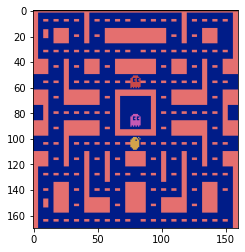

In [ ]:
# Sample a random state to checkout what it looks like
env.reset()
state, reward, done, info = env.step(3)
image = state

x = 0
y = 0
w = 160
h = 170

print('type:', type(image))
crop_img = image[y:y+h, x:x+w,:]
plt.imshow(crop_img)
plt.show()

## State collection

In [ ]:
# rendering
plt.figure(figsize = (60,10))
render = lambda : plt.imshow(env.render(mode='rgb_array')) # plotting function

env.reset()
state, reward, done, info = env.step(1)

def reformat_state(state):
    x = 0
    y = 0
    w = 160
    h = 170

    state = state[y:y+h, x:x+w,:]
    return state

def collect_states(runs):
    state_list = []
    for i in range(runs):    # how many runs
        print(f"run: {i}")

        done = False

        env.reset()
        state, reward, done, info = env.step(1)
        lives = info['ale.lives']

        counter = 0

        for j in range(10000):    # steps in the environment

            if done != True:
                action = env.action_space.sample()
                state, reward, done, info = env.step(action)
            else: 
                break
            
            if lives > info['ale.lives']:
                lives = info['ale.lives']
                counter = 0 

            if counter > 90:   # avoid the first 90 steps
                state_list.append(reformat_state(state).flatten())

            counter += 1


    random.shuffle(state_list)
    return state_list

collected_states = collect_states(10)
# 10 gives 6906 frames

run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9


<Figure size 4320x720 with 0 Axes>

In [ ]:
# Visualise the first 100 collected states (for debugging)
for i in range(100): # range(len(collected_states)):

    if i % 1 == 0:
        print(i)
        plt.imshow(collected_states[i].reshape(170, 160, 3))
        plt.show()

In [ ]:
# Checkout the in-memory size of the collected states
sys.getsizeof(collected_states)

30128

In [ ]:
# Save the collected states to the harddrive
for i in range(5):
    collected_states = collect_states(10)
    np.save(f"VAE-input-new/collected_states_{i}.npy", collected_states)

## Checkout the behavior of a random agent

In [ ]:
# outer collector
meta_cumulative_reward = []
meta_counter = []

for i in range(100):

    # setting the environment
    env.reset()
    env.step(1)

    # inner collector
    cumulative_reward = 0 
    counter = 0 

    done = False

    # stop when done flag is raised
    while done != True:
        a = random.sample(range(0, 8), 1)   # choose action randomly
        state, reward, done, info = env.step(a)

        # keep track
        cumulative_reward += reward
        counter += 1
    
    meta_cumulative_reward.append(cumulative_reward)
    meta_counter.append(counter)

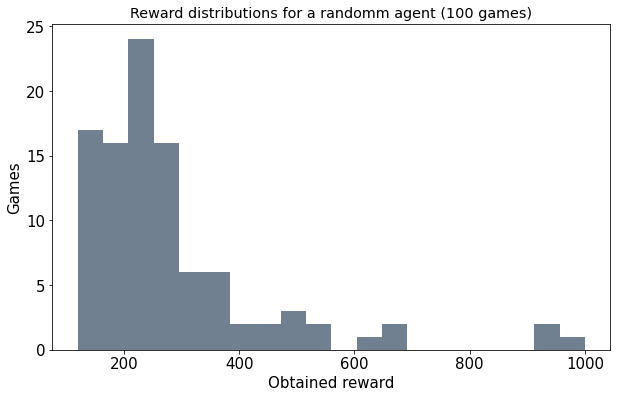

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

# plot results
plt.figure(figsize=(10, 6))
plt.hist(meta_cumulative_reward, density=False, bins=20, color='slategray')
plt.style.use('ggplot')
plt.title('Reward distributions for a randomm agent (100 games)')
plt.ylabel('Games')
plt.xlabel('Obtained reward');
plt.savefig('random-agent-pinball.pdf')
plt.show()